# Аналитика данных. Домашнее задание 3. Коломыцева Анна

In [4]:
# импортируем библиотеки
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('community_dataset.csv')
display(data.head())

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction,cell_type,case_id,area_of_cell,age_group
0,988.509380,612.076506,10.803755,187.998971,community_1,Stroma cells,891,185,elder_group
1,787.852379,637.787202,11.749179,155.357076,community_1,Stroma cells,891,209,elder_group
2,960.635580,700.283468,15.124372,182.626888,community_2,Stroma cells,891,254,elder_group
3,702.033032,676.409695,14.221883,158.381917,community_3,Unclassified,891,156,elder_group
4,830.399371,863.269930,19.978977,159.071269,community_3,Unclassified,891,194,elder_group


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269442 entries, 0 to 269441
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   distance_to_vasculature   269442 non-null  float64
 1   distance_to_largest_cell  269442 non-null  float64
 2   immune_marker_1           269442 non-null  float64
 3   immune_marker_2           269442 non-null  float64
 4   cell_interaction          269442 non-null  object 
 5   cell_type                 269442 non-null  object 
 6   case_id                   269442 non-null  int64  
 7   area_of_cell              269442 non-null  int64  
 8   age_group                 269442 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 18.5+ MB


In [7]:
# найдем и удалим дубликаты
def dedupp(df):
    dupl_columns = list(df.columns)

    mask = df.duplicated(subset=dupl_columns)
    df_duplicates = df[mask]
    print(f'Число найденных дубликатов: {df_duplicates.shape[0]}')

    dedupped = df.drop_duplicates(subset=dupl_columns)
    print(f'Результирующее число записей: {dedupped.shape[0]}')
    return dedupped

data = dedupp(data)

Число найденных дубликатов: 0
Результирующее число записей: 269442


В данных нет явных дубликатов и пропущенных значений

Столбцы датасета:
- distance_to_vasculature — расстояние до ближайших сосудов;
- distance_to_largest_cell — расстояние до ближайшей крупной клетки;
- immune_marker_1 — экспрессия иммунного маркера 1 в данной клетке;
- immune_marker_2 — экспрессия иммунного маркера 2 в данной клетке;
- cell_interaction — микроокружение;
- cell_type — тип клетки;
- area_of_cell — размер клетки;
- case_id — уникальный ID пациента;
- age_group — возрастная группа.

## Задача 1a
Есть ли стат-значимость между типом клетки (cell_type) и размером клетки (area_of_cell), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

In [8]:
# функция постоения боксплота, где по одной оси - тип клеток, а по другой - оцениваемая статистика
def box_plot(df, statistic):
    fig = plt.figure(figsize=(11, 7))
    boxplot = sns.boxplot(
        data=df,
        x='cell_type',
        y=statistic,
        width=0.8,
        hue='age_group'
    )
    boxplot.set_title(f'Распределение {statistic} по типам клеток');
    boxplot.set_ylabel(statistic);
    boxplot.set_xlabel('cell_type');
    boxplot.grid()
    
    
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [9]:
warnings.simplefilter(action="ignore", category=UserWarning)
# функция для графика квантиль-квантиль
def qq_plots(data, parametr):
    fig, axs = plt.subplots(8, 2, figsize=(10, 25))
    plt.subplots_adjust(wspace=0.5, hspace=1)
    for i in range(2):
        age = data.age_group.unique()[i]
        df_age = data[data.age_group == age]
        for j in range(8):
            type = data.cell_type.unique()[j]
            df = df_age[data.cell_type == type]
            stats.probplot(df[parametr], dist="norm", plot=axs[j, i])
            axs[j, i].set_title(f'QQ для {parametr} клеток {type} \n в возрастной группе {age}')            
    plt.show()
    

In [10]:
from scipy.stats import anderson # тест Андерсона-Дарлинга
# https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson

def subfuntion(df0, type, parametr):
    df = df0[df0.cell_type == type]
    alpha = 0.05
    p1, crit_values, signif_level = anderson(df[parametr])
    # Критическое значение для нашего α равно:
    critical_value = crit_values[signif_level.tolist().index(alpha*100)]
    #print('Тест Андерсона-Дарлинга p=%.3f' % p1, 'critical_value=%.3f' % critical_value)
    # Если тестовая статистика p1 не превышает критического значения, результаты не являются значимыми, 
    # не отвергаем нулевую гипотезу.
    # Интерпретация
    if p1 <= critical_value:
        return True
    else:
        return False

# функция проверки на нормальность с помощью стат теста Андерсона-Дарлинга
def normal_anderson(data, parametr):
    #H0 = 'Данные распределены нормально'
    #Ha = 'Данные не распределены нормально (мы отвергаем H0)'

    types = list(data['cell_type'].unique())
    table = pd.DataFrame({'cell_type': types})
    for age in data.age_group.unique():
        df_age = data[data.age_group == age]
        table[age] = table['cell_type'].apply(lambda x: subfuntion(df_age, x, parametr))
    return table

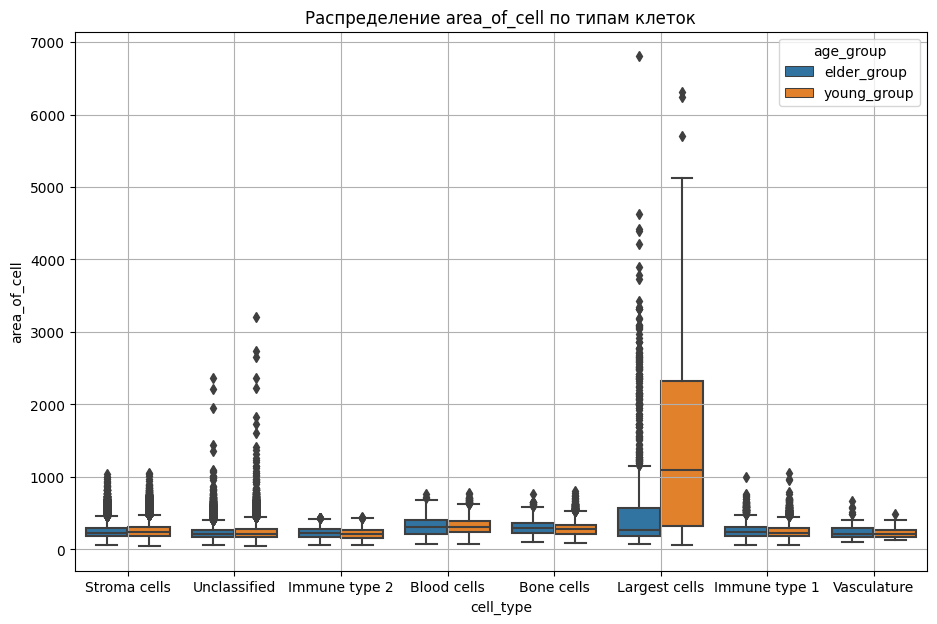

In [11]:
# а) Размер клетки (area_of_cell)
# строим boxplot
box_plot(data, 'area_of_cell')

Из боксплота заметно большее среднее значение и больший разброс для крупных клеток (Largest cells), особенно в младшей возрастной группе. Это соответствует названию типа (можно было предположить). С возрастом, видимо размер этих клеток в среднем приближается к размеру остальных тапов клеток.

Прежде чем выбирать стат. тест, проверим нормально или нет распределаны интересующие нас данные

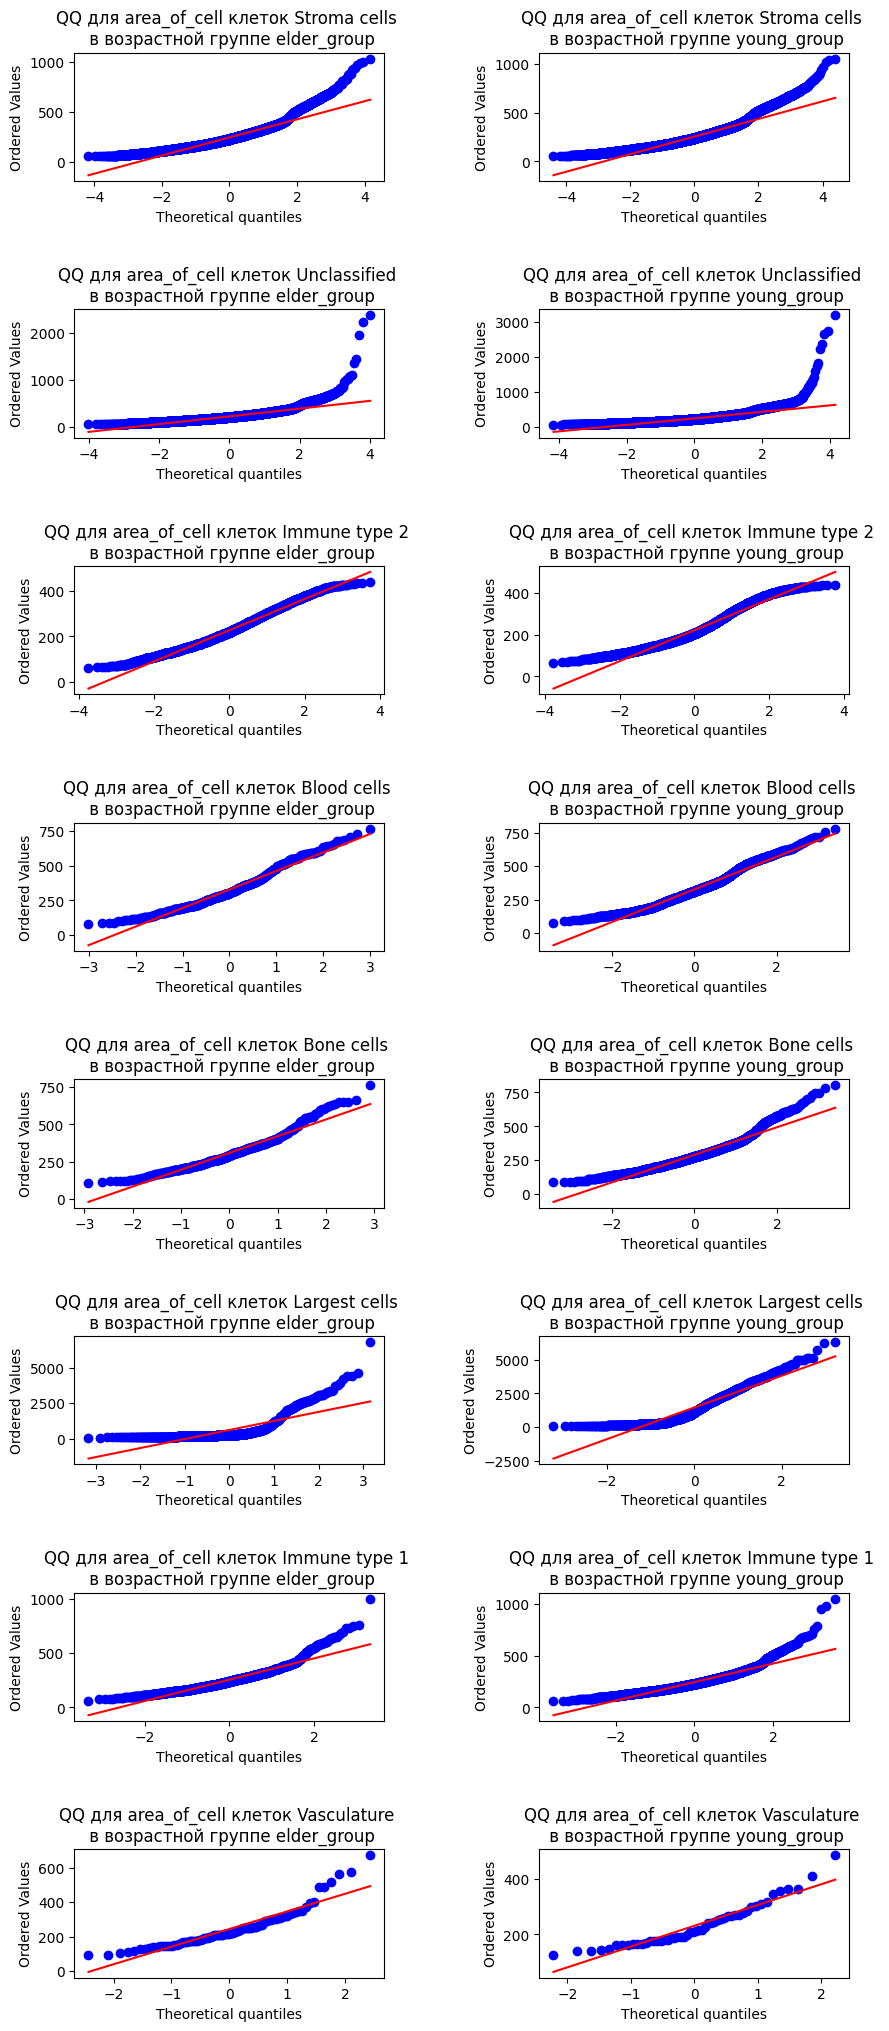

,cell_type,elder_group,young_group
0,Stroma cells,False,False
1,Unclassified,False,False
2,Immune type 2,False,False
3,Blood cells,False,False
4,Bone cells,False,False
5,Largest cells,False,False
6,Immune type 1,False,False
7,Vasculature,False,False


In [12]:
# проверка на нормальность распределений
qq_plots(data, 'area_of_cell')
display(normal_anderson(data, 'area_of_cell'))

Из графиков qq и теста Андерсона-Дарлинга делаем вывод, что  распределение переменной area_of_cell для каждой комбинации cell_type и age_group не является нормальным.

Нужно выявить связь или ее отсутсвие между категориальными переменными - типом клетки и возрастной группой - и рядом количественных. Поскольку проверка показала несоответсвие нормальному распределению, выберем непараметрические тесты.

Используем **H-критерий Крускала-Уоллиса** для независимых выборок, который проверяет нулевую гипотезу о том, что медиана всех групп одинакова. Это непараметрическая версия ANOVA. Тест работает на 2 или более независимых выборках, которые могут иметь разные размеры. Отклонение нулевой гипотезы не указывает, какая из групп отличается. Для определения того, какие группы отличаются, требуются специальные сравнения между группами.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html 


In [13]:
from scipy.stats import kruskal

def kruskal_test(sample1, sample2, category, parameter, alpha = 0.05):
    # гипотезы
    H0 = f"Нет значимых различий между медианами {parameter} всех {category}"
    Ha = f"Есть различия между медианами параметра {parameter} различных {category}"

    test_res = kruskal(sample1[parameter], sample2[parameter])
    print(f'Тест Крускала-Уоллиса для {parameter}: {test_res}')
    if test_res.pvalue > alpha:
        result = H0
    else:
        result = Ha
    return result

Сравним распределения для Largest cells в зависимости от возраста

In [14]:
Largest_cell_elder = data[(data['cell_type']=='Largest cells') & (data['age_group']=='elder_group')]
Largest_cell_young = data[(data['cell_type']=='Largest cells') & (data['age_group']=='young_group')]
print(kruskal_test(Largest_cell_elder, Largest_cell_young, 'age_group', 'area_of_cell'))

Тест Крускала-Уоллиса для area_of_cell: KruskalResult(statistic=327.76234627595915, pvalue=2.9522713980296525e-73)
Есть различия между медианами параметра area_of_cell различных age_group


Т.к p-value много меньше 0.05, тест подтверждает наличение значимой разницы размеров крупных клеток между возрастными группами

## Задача 1б
Есть ли стат-значимость между типом клетки (cell_type) и экспрессией иммунных маркеров (immune_marker_1, immune_marker_2), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

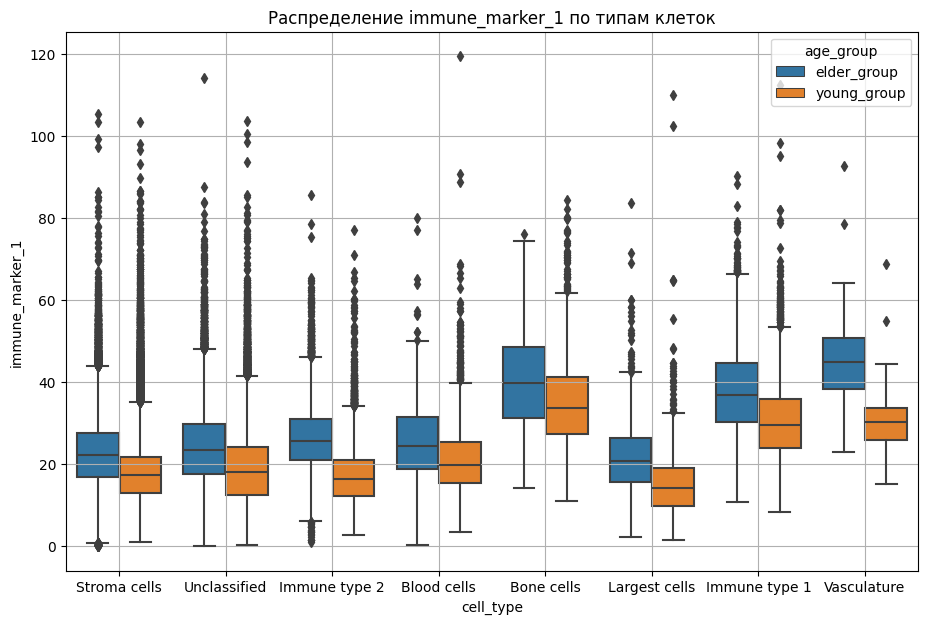

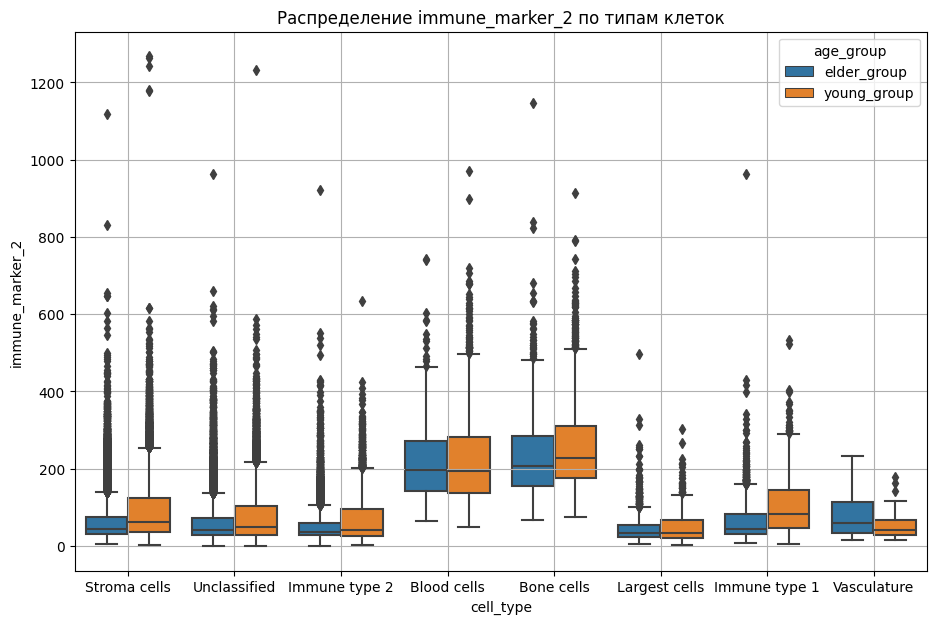

In [15]:
# б) Экспрессия иммунных маркеров (immune_marker_1, immune_marker_2)
box_plot(data, 'immune_marker_1')
box_plot(data, 'immune_marker_2')

Для экспрессии иммунных маркеров (immune_marker_1) наблюдаются более высокие средние значения у старшей возрастной группы и большие, по сравнению с другими типам, значения у клеток Bone cells, Immune type 1, Vasculature.

Для immune_marker_2 из графика нельзя определенно выявить значимую разницу в зависимости от возрастных групп, а среди типов клеток большими показателями отличаются Blood cells и Bone cells.

Стат. тест выбираем аналогично заданию 1а. Если данные распределены не нормально, используем Н-критерий Крускала-Уоллиса.

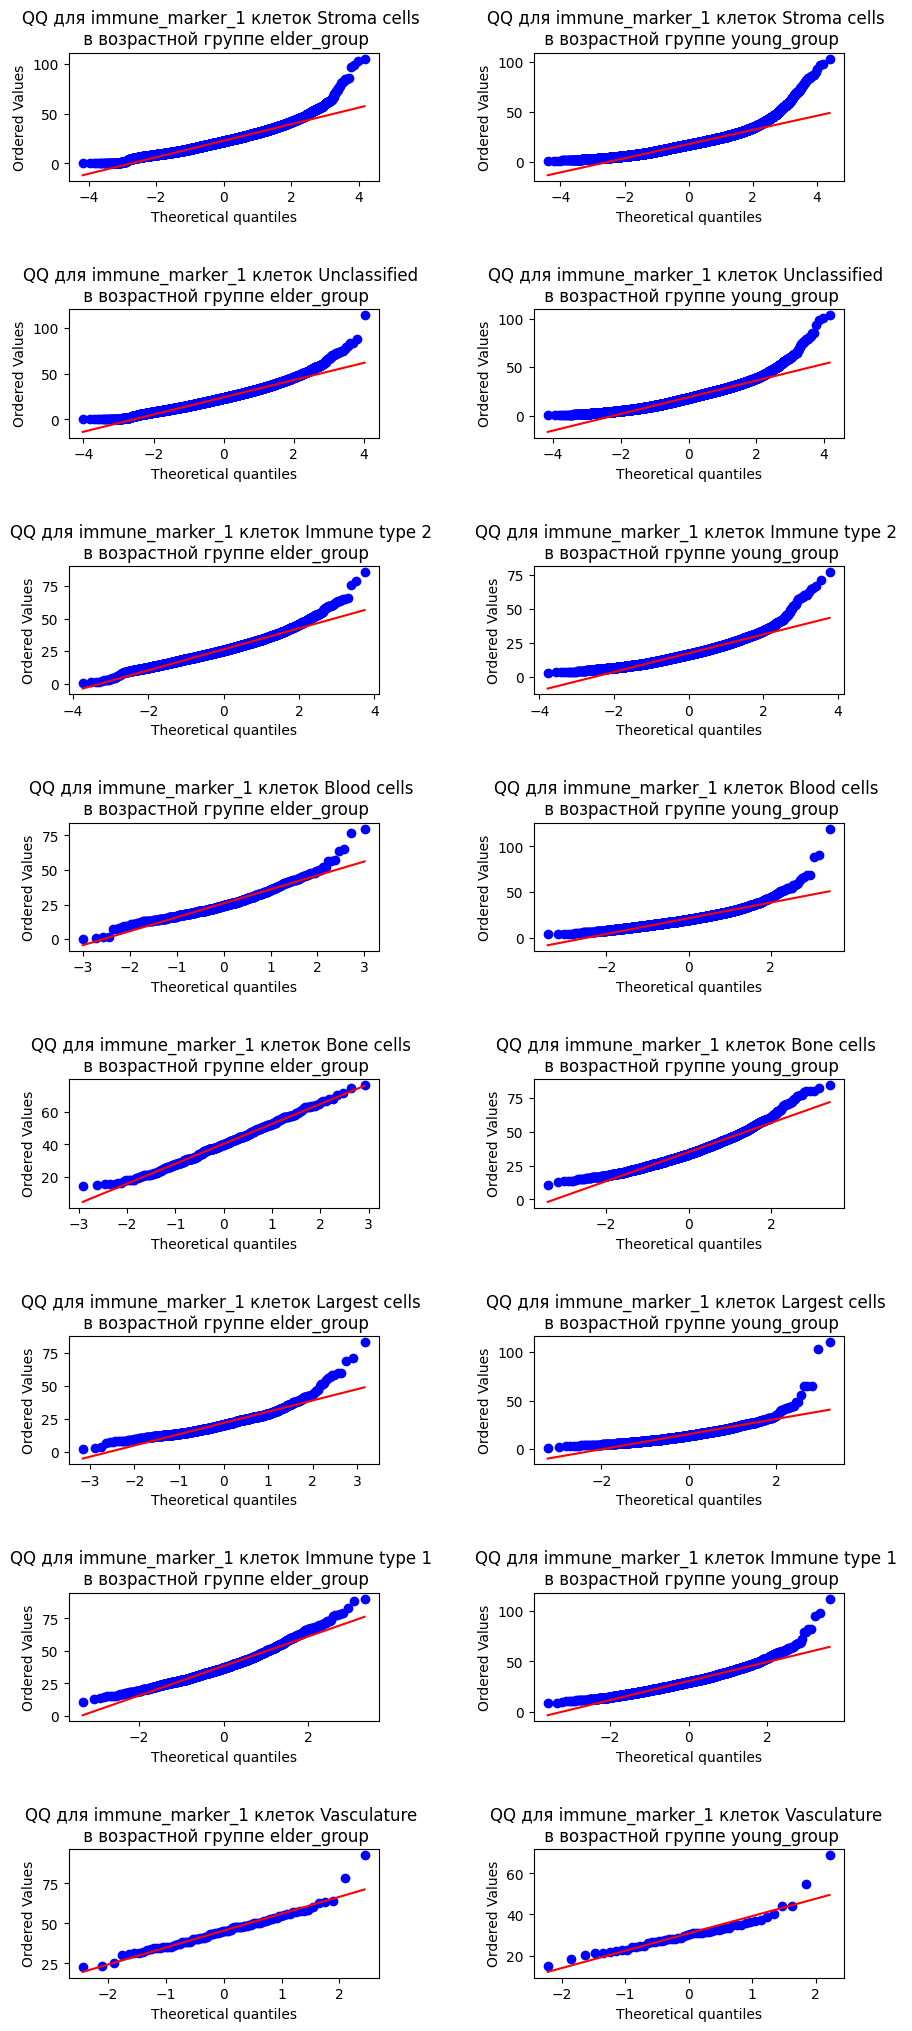

,cell_type,elder_group,young_group
0,Stroma cells,False,False
1,Unclassified,False,False
2,Immune type 2,False,False
3,Blood cells,False,False
4,Bone cells,True,False
5,Largest cells,False,False
6,Immune type 1,False,False
7,Vasculature,True,False


In [16]:
# проверка на нормальность распределений
qq_plots(data, 'immune_marker_1')
display(normal_anderson(data, 'immune_marker_1'))

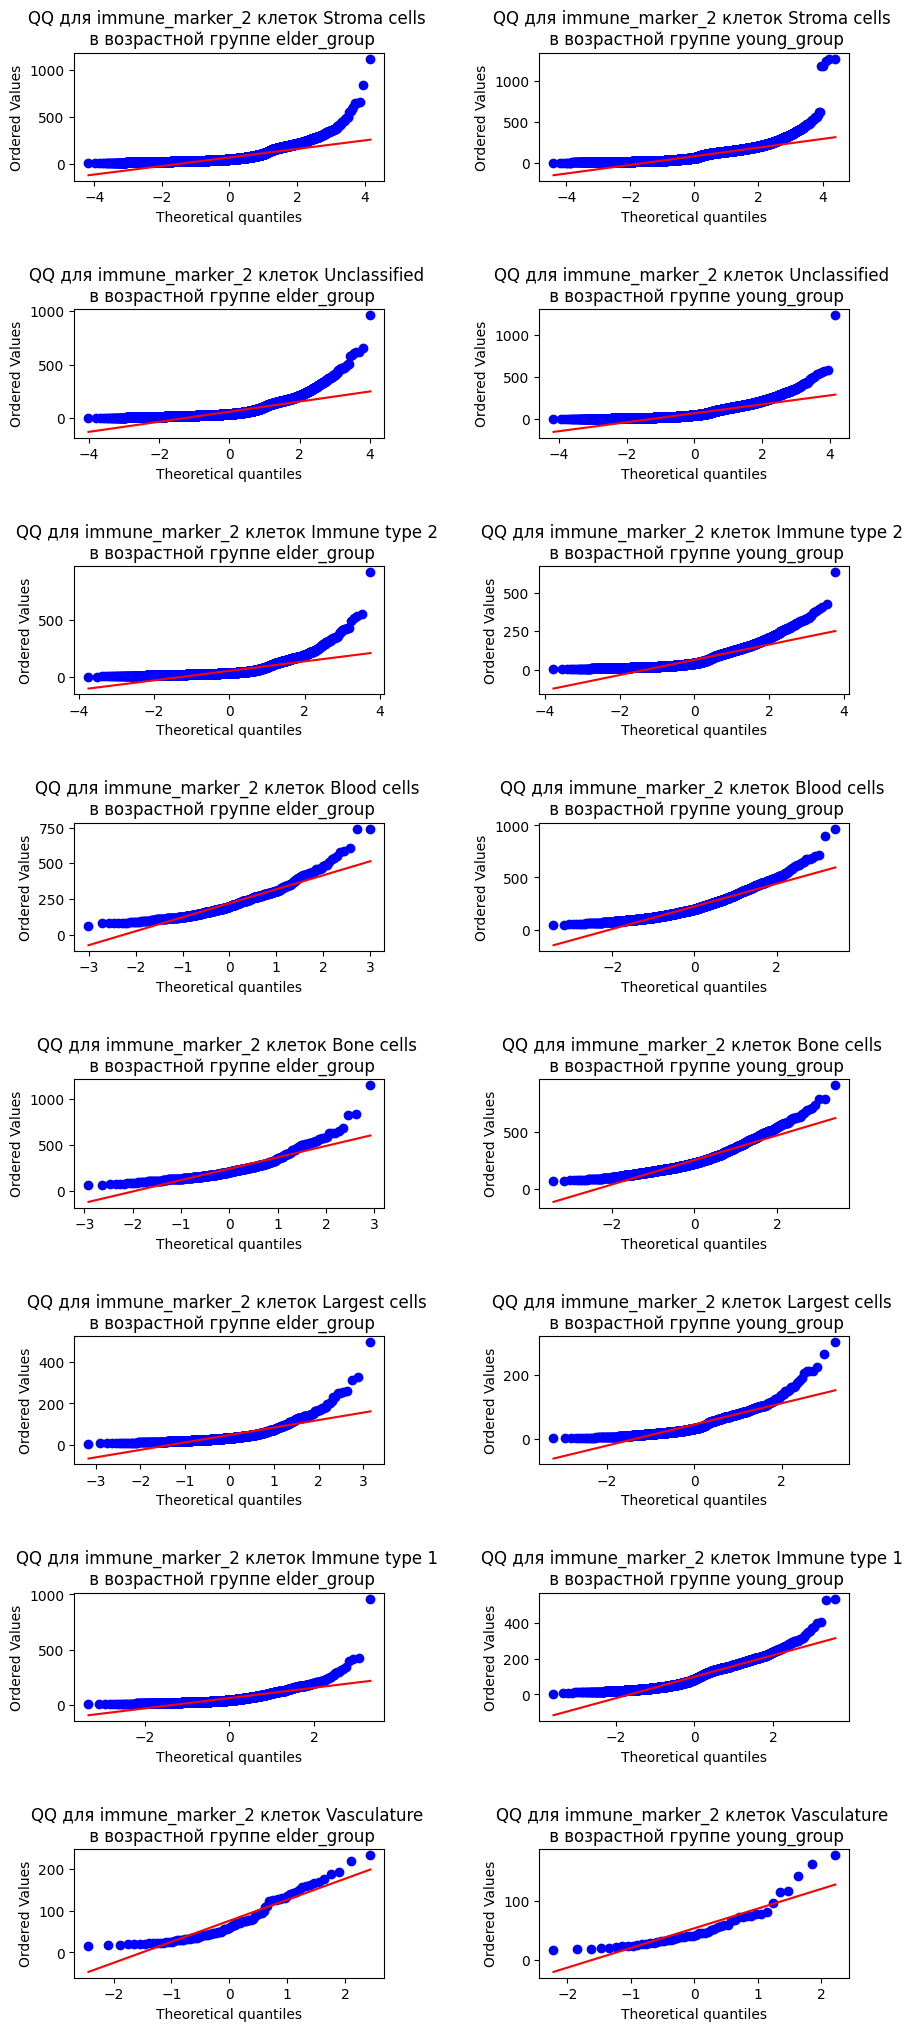

,cell_type,elder_group,young_group
0,Stroma cells,False,False
1,Unclassified,False,False
2,Immune type 2,False,False
3,Blood cells,False,False
4,Bone cells,False,False
5,Largest cells,False,False
6,Immune type 1,False,False
7,Vasculature,False,False


In [17]:
# проверка на нормальность распределений
qq_plots(data, 'immune_marker_2')
display(normal_anderson(data, 'immune_marker_2'))

Сравним возрастные группы по параметру экспрессии иммунных маркеров immune_marker_1 и immune_marker_2

In [18]:
sample_elder = data[data['age_group']=='elder_group']
sample_young = data[data['age_group']=='young_group']
print(kruskal_test(sample_elder, sample_young, 'age_group', 'immune_marker_1'))
print(kruskal_test(sample_elder, sample_young, 'age_group', 'immune_marker_2'))

Тест Крускала-Уоллиса для immune_marker_1: KruskalResult(statistic=22550.479284726465, pvalue=0.0)
Есть различия между медианами параметра immune_marker_1 различных age_group
Тест Крускала-Уоллиса для immune_marker_2: KruskalResult(statistic=5892.728555588947, pvalue=0.0)
Есть различия между медианами параметра immune_marker_2 различных age_group


Для обоих типов иммунных маркеров тест Крускала-Уоллиса выявил значимые различия между возрастными группами

Теперь проверим, есть ли значимые различия между типами клеток по параметру экспрессии иммунных маркеров immune_marker_1

In [19]:
# составим список выборок
imm_marker_1_samples = []
for type in data['cell_type'].unique():
    imm_marker_1_samples.append(data[data['cell_type']==type]['immune_marker_1'])
# проведем тест Крускала-Уоллиса
test_res = kruskal(*imm_marker_1_samples)
print(f'Тест Крускала-Уоллиса для immune_marker_1: {test_res}')

Тест Крускала-Уоллиса для immune_marker_1: KruskalResult(statistic=14973.788330087895, pvalue=0.0)


In [20]:
# составим список выборок
imm_marker_2_samples = []
for type in data['cell_type'].unique():
    imm_marker_2_samples.append(data[data['cell_type']==type]['immune_marker_2'])
# проведем тест Крускала-Уоллиса
test_res = kruskal(*imm_marker_2_samples)
print(f'Тест Крускала-Уоллиса для immune_marker_2: {test_res}')

Тест Крускала-Уоллиса для immune_marker_2: KruskalResult(statistic=17837.48216937282, pvalue=0.0)


Т.к. значения p-value близки к 0.0, есть статистически значимые различия в экспрессии immune_marker_1 и immune_marker_2  между группами по типам клеток

## Задача 1в
Есть ли стат-значимость между типом клетки (cell_type) и дистанцией до ближайших объектов (distance_to_vasculature, distance_to_largest_cell), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

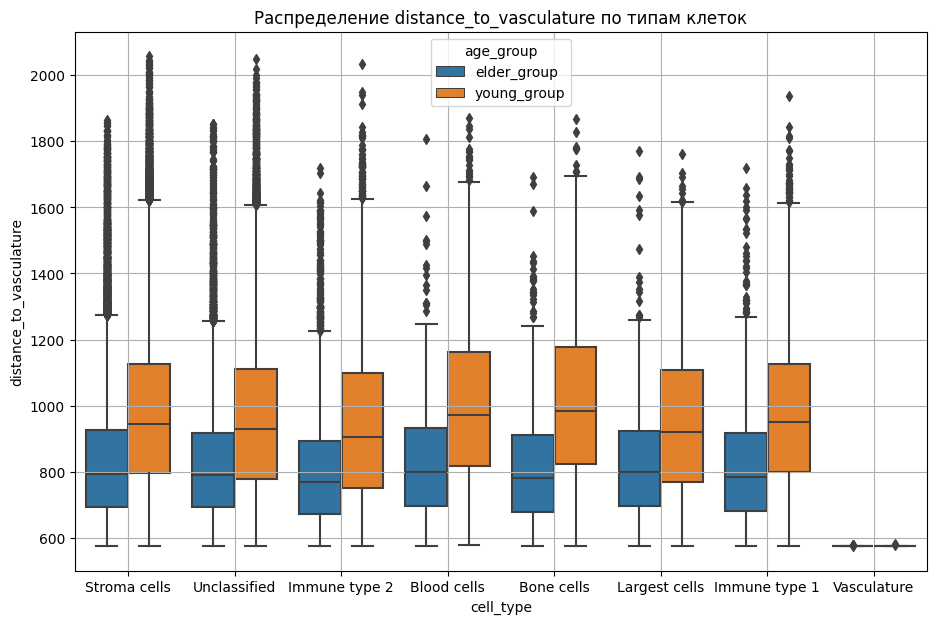

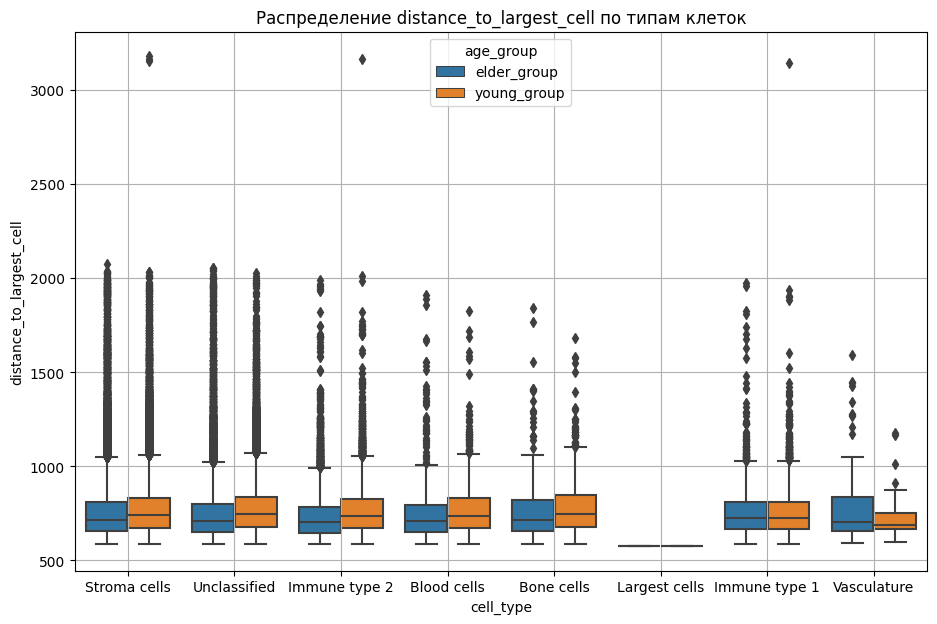

In [21]:
# в) Дистанция до ближайших объектов (distance_to_vasculature, distance_to_largest_cell)
box_plot(data, 'distance_to_vasculature')
box_plot(data, 'distance_to_largest_cell')

Расстояние до ближайших сосудов и до крупных клеток, судя по графику, с возрастом уменьшается. Значимых различий между типами клеток по этим параметрам не выявлено.

Стат. тест выбираем аналогично заданию 1а. Если данные распределены не нормально, используем Н-критерий Крускала-Уоллиса.

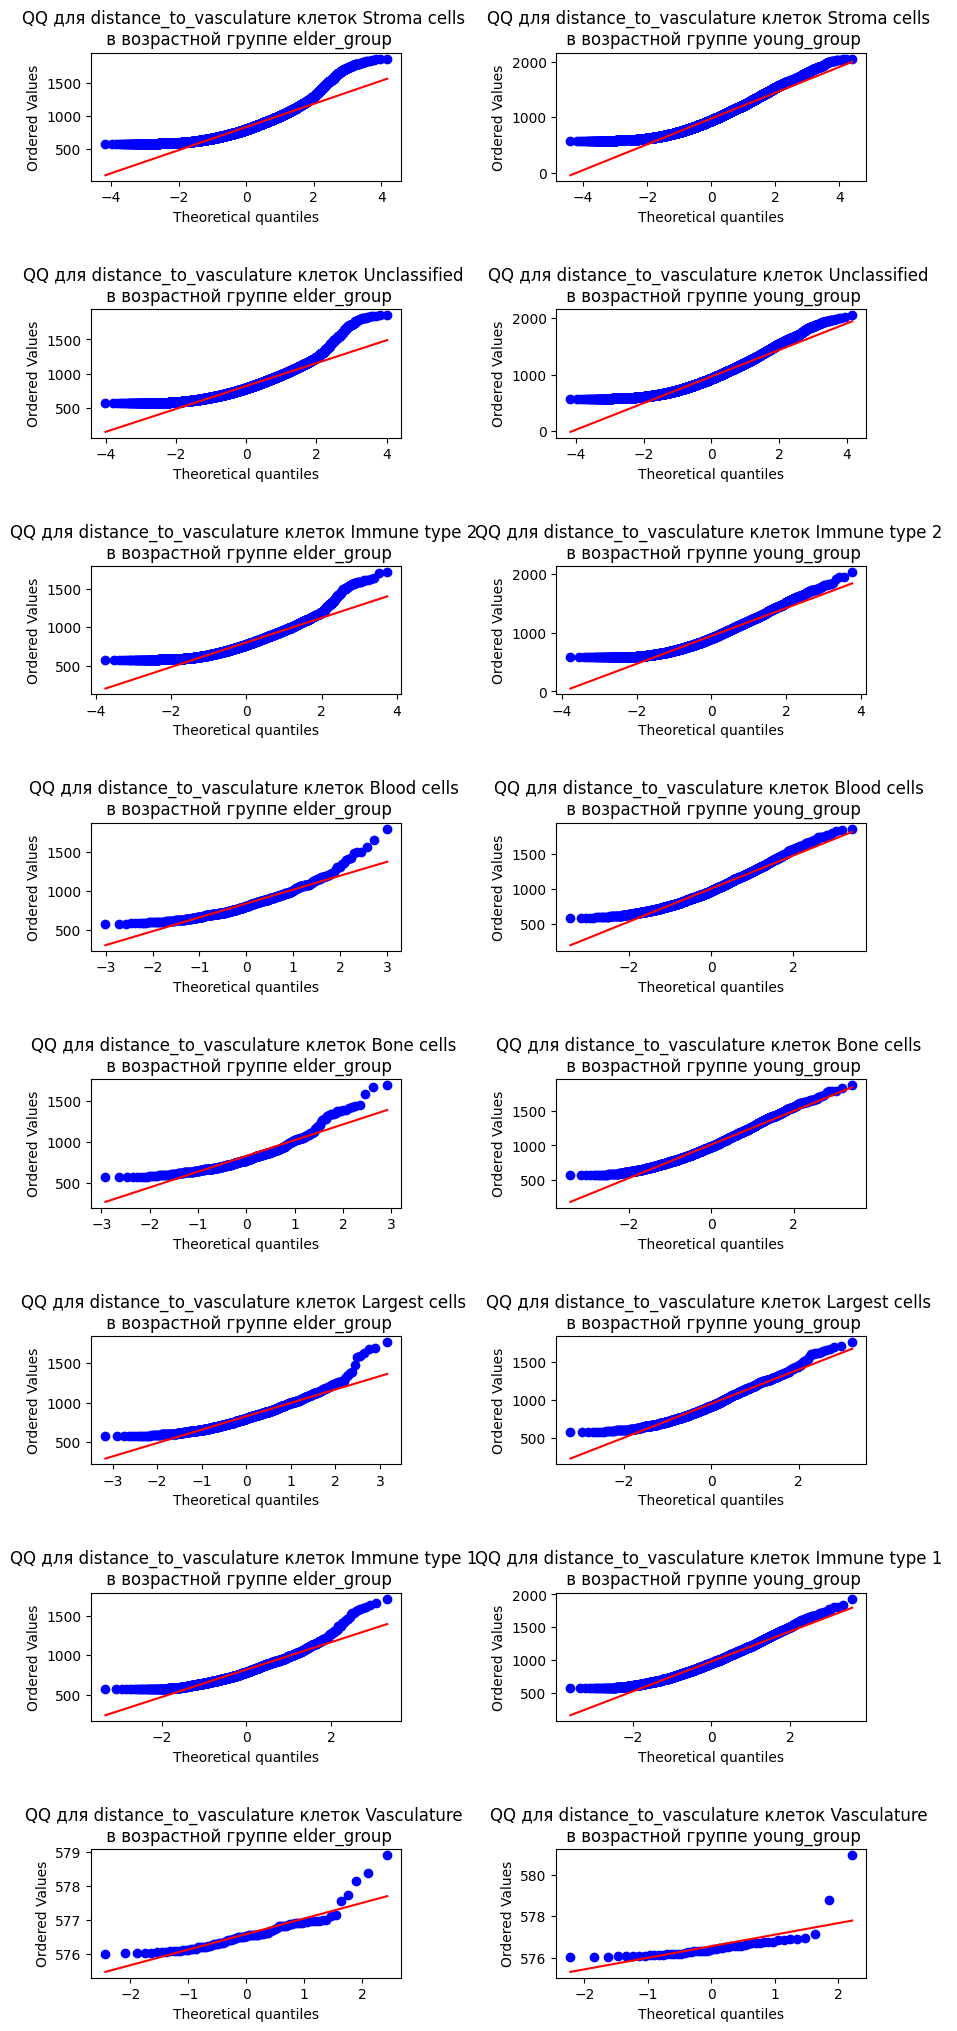

,cell_type,elder_group,young_group
0,Stroma cells,False,False
1,Unclassified,False,False
2,Immune type 2,False,False
3,Blood cells,False,False
4,Bone cells,False,False
5,Largest cells,False,False
6,Immune type 1,False,False
7,Vasculature,False,False


In [22]:
# проверка на нормальность распределений
qq_plots(data, 'distance_to_vasculature')
display(normal_anderson(data, 'distance_to_vasculature'))

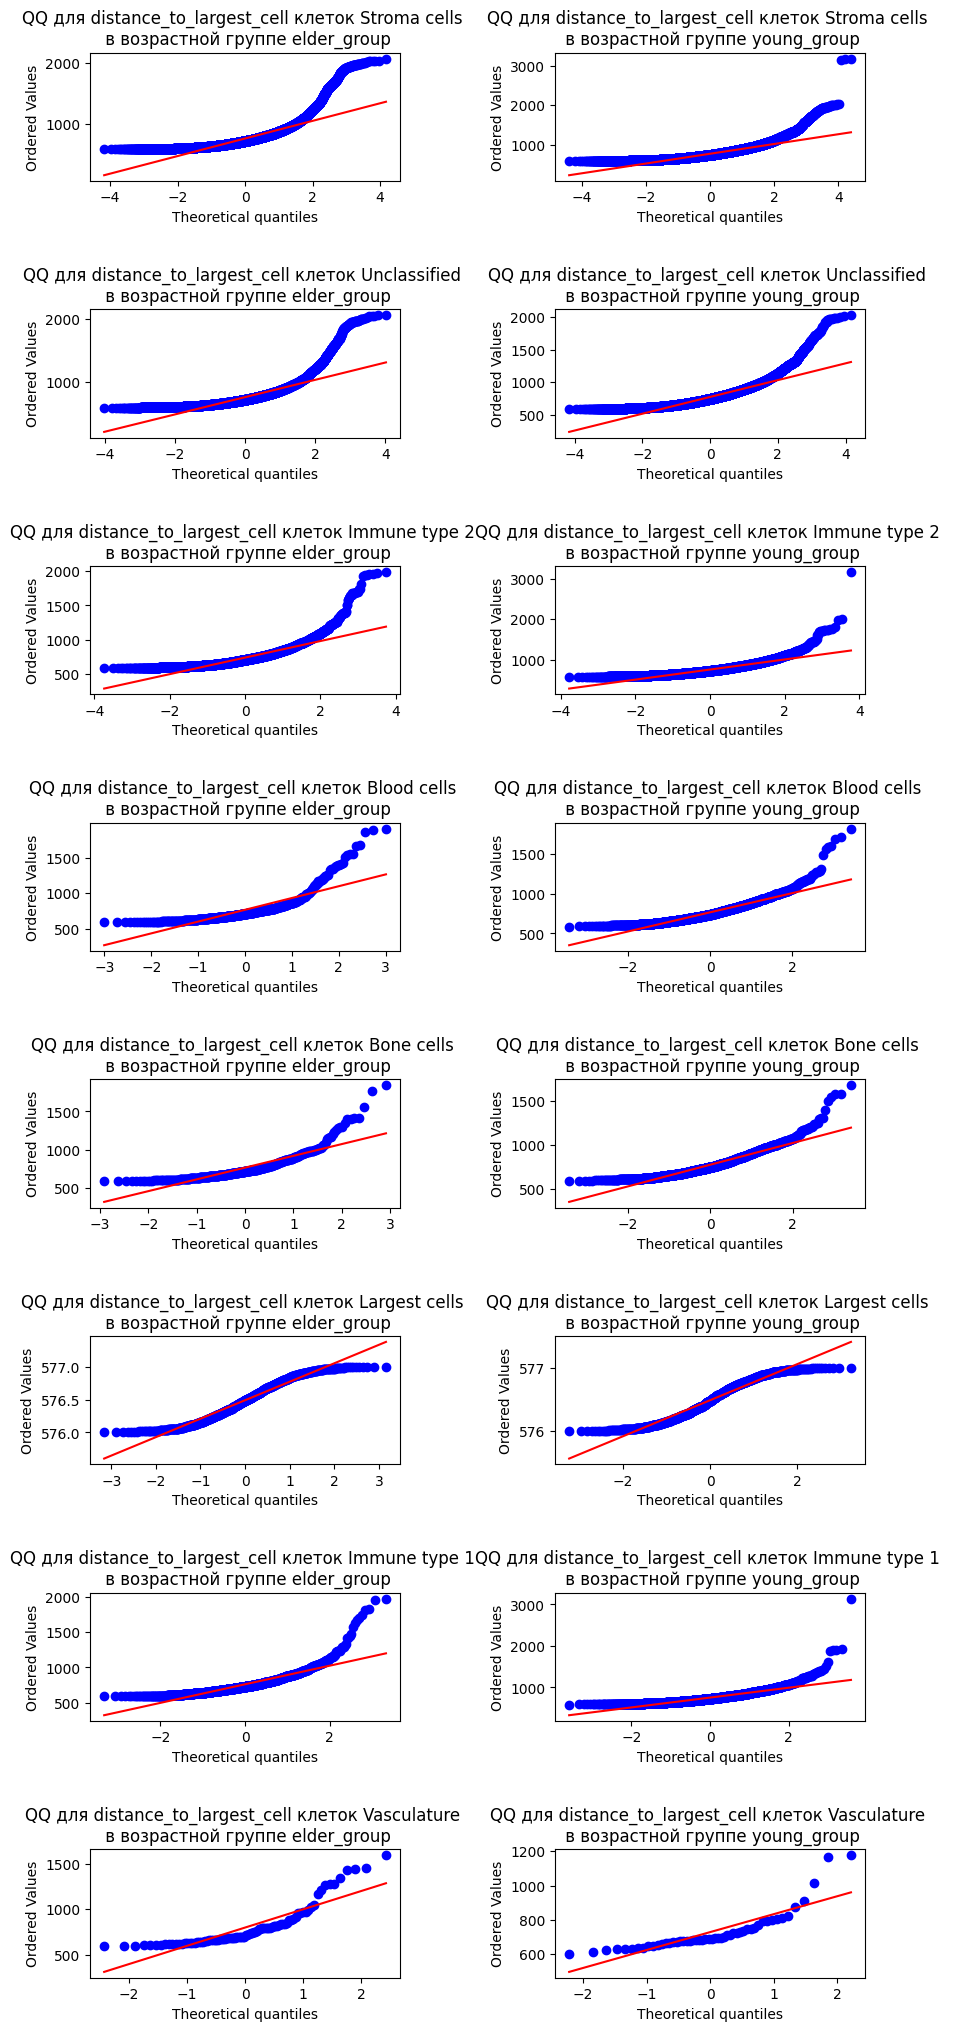

,cell_type,elder_group,young_group
0,Stroma cells,False,False
1,Unclassified,False,False
2,Immune type 2,False,False
3,Blood cells,False,False
4,Bone cells,False,False
5,Largest cells,False,False
6,Immune type 1,False,False
7,Vasculature,False,False


In [23]:
# проверка на нормальность распределений
qq_plots(data, 'distance_to_largest_cell')
display(normal_anderson(data, 'distance_to_largest_cell'))

Проведем тест на значимые различия между типами клеток для расстояний до сосудов и крупных клеток для старшей возрастной группы

In [24]:
# составим список выборок
dist_to_vascul_samples = []
for type in data['cell_type'].unique():
    dist_to_vascul_samples.append(
        data[(data['cell_type']==type) & (data['age_group']=='elder_group')]['distance_to_vasculature'])
# проведем тест Крускала-Уоллиса
test_res = kruskal(*dist_to_vascul_samples[0:7])
print(f'Тест Крускала-Уоллиса для distance_to_vasculature: {test_res}')

Тест Крускала-Уоллиса для distance_to_vasculature: KruskalResult(statistic=186.72031711571617, pvalue=1.267051917138471e-37)


In [25]:
# составим список выборок
dist_to_largest_samples = []
for type in data['cell_type'].unique():
    dist_to_largest_samples.append(
        data[(data['cell_type']==type) & (data['age_group']=='elder_group')]['distance_to_largest_cell'])
# проведем тест Крускала-Уоллиса
test_res = kruskal(*dist_to_largest_samples[0:5], *dist_to_largest_samples[6:])
print(f'Тест Крускала-Уоллиса для distance_to_largest_cell: {test_res}')

Тест Крускала-Уоллиса для distance_to_largest_cell: KruskalResult(statistic=152.3492803077097, pvalue=2.464712472410651e-30)


P-value близки к 0.0, это показывает, что расстояния до сосудов и крупных клеток для старшей возрастной группы зависят от типа клеток, т.е. показатели хотя бы одного типа клеток отличные от остальных.

Проверим расстояния до сосудов и крупных клеток на зависимость от возраста.

In [26]:
print(kruskal_test(sample_elder, sample_young, 'age_group', 'distance_to_vasculature'))
print(kruskal_test(sample_elder, sample_young, 'age_group', 'distance_to_largest_cell'))

Тест Крускала-Уоллиса для distance_to_vasculature: KruskalResult(statistic=25172.49081454985, pvalue=0.0)


Есть различия между медианами параметра distance_to_vasculature различных age_group
Тест Крускала-Уоллиса для distance_to_largest_cell: KruskalResult(statistic=2627.227977383067, pvalue=0.0)
Есть различия между медианами параметра distance_to_largest_cell различных age_group


По результатам теста получены p-value близкие к 0, что подтверждает статистическую значимость для предположения, сделанного на основе boxplot

### Результаты задачи 1
В ходе выполнения задачи 1 подтверждены гипотезы о том, что есть стат-значимость между типом клетки и размером клетки (area_of_cell),экспрессией иммунных маркеров (immune_marker_1, immune_marker_2), дистанцией до ближайших объектов (distance_to_vasculature, distance_to_largest_cell), а также между этими праметрами и возрастной группой.

**Из возможных улучшений:** для более подробного анализа можно формировать выборки по типам клеток отдельно для каждой возрастной группы и проводить post-hoc анализ для выявления конкретных групп, между которыми имеются различия.

## Задача 2:
В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка cell_interaction). Для ответа используйте box_plot/swarplot с hue по микроокружениям, где:

- по Ох будут типы клеток,
- по Оу — их количество

Необходимо посчитать количество для каждого пациента отдельно, иначе выборка не будет репрезентативной.

,case_id,cell_interaction,cell_type,count
0,40,community_1,Blood cells,37
1,40,community_1,Bone cells,27
2,40,community_1,Immune type 1,27
3,40,community_1,Immune type 2,1343
4,40,community_1,Largest cells,67
...,...,...,...,...
366,983,community_6,Immune type 1,127
367,983,community_6,Immune type 2,211
368,983,community_6,Largest cells,100
369,983,community_6,Stroma cells,2278


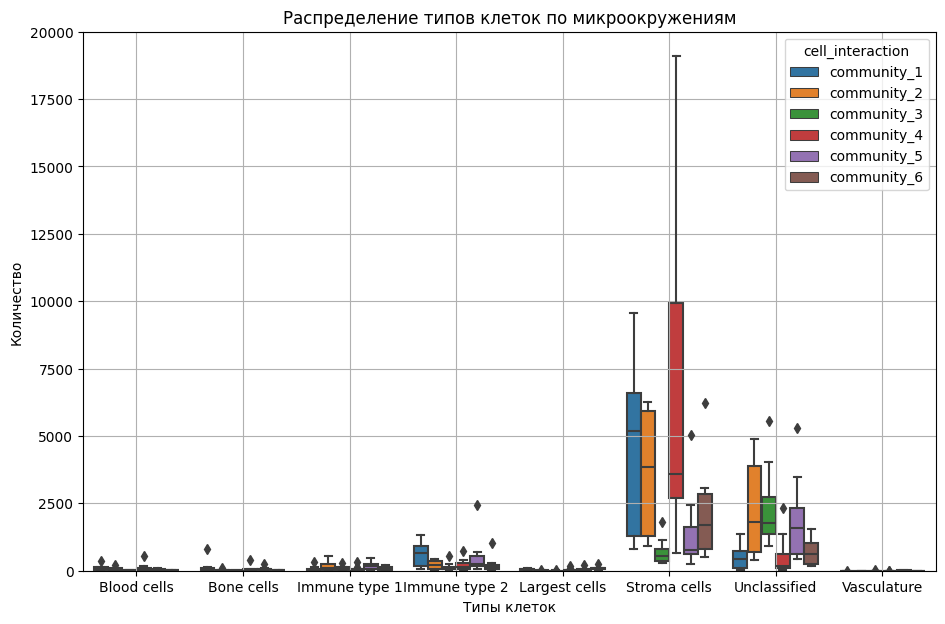

In [27]:
# формируем набот данных - группируем по номеру пациента, микроокружения и типу клеток
sample_task2 = (data
    .groupby(['case_id', 'cell_interaction', 'cell_type'])
    .size()
    .reset_index(name='count'))
display(sample_task2)

fig = plt.figure(figsize=(11, 7))
ax = sns.boxplot(
    data=sample_task2,
    x='cell_type',
    y='count',
    width=0.8,
    hue='cell_interaction'
)
ax.set_title('Распределение типов клеток по микроокружениям');
ax.set_ylabel('Количество');
ax.set_xlabel('Типы клеток');
plt.ylim(0, 20000)
ax.grid()


- Стромальных клеток статистически больше в микроокружениях 1, 2, 4, 6;
- Неклассифицированных клеток - в микроокружениях 3, 5.

Покажем статистическую значимость между Stroma cells и Unclassified в раздичных микроокружениях с помощью теста Манна-Уитни.U-критерий Манна-Уитни является непараметрическим критерием и не требует наличия нормального распределения сравниваемых совокупностей; подходит для сравнения малых независимых выборок. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

alternative: {‘two-sided’, ‘less’, ‘greater’}

In [28]:
from scipy.stats import mannwhitneyu

alpha = 0.05
H0 = 'Нет значимых различий между Stroma cells и Unclassified клетками'
H1 = 'Есть значимые различия между Stroma cells и Unclassified клетками'

for i in range(1, 7):
    sample_Stroma = sample_task2['count'][
        (sample_task2['cell_type'] == 'Stroma cells') &
        (sample_task2['cell_interaction'] == f'community_{i}')]
    sample_Unclassified = sample_task2['count'][
        (sample_task2['cell_type'] == 'Unclassified') &
        (sample_task2['cell_interaction'] == f'community_{i}')]
    # предполагаем, что стромальных клеток статистически больше в микроокружениях 1, 2, 4, 6;
    # неклассифицированных клеток - в микроокружениях 3, 5.
    alter = 'less' if (i==3 or i==5) else 'greater'
    stat, p = mannwhitneyu(sample_Stroma, sample_Unclassified, alternative=alter)
    print(f'Для {i}-го микроокружения U-статистика: {stat}, p-значение: {p}')
    if p < alpha:
        print(f'Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу: {H1} в {i}-м микроокружении при a = {alpha}')
    else:
        print(f'Не отвергаем нулевую гипотезу: {H0} в {i}-м микроокружении при a = {alpha}')
        

Для 1-го микроокружения U-статистика: 61.0, p-значение: 0.0005439005439005439
Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу: Есть значимые различия между Stroma cells и Unclassified клетками в 1-м микроокружении при a = 0.05
Для 2-го микроокружения U-статистика: 46.0, p-значение: 0.08026418026418025
Не отвергаем нулевую гипотезу: Нет значимых различий между Stroma cells и Unclassified клетками в 2-м микроокружении при a = 0.05
Для 3-го микроокружения U-статистика: 6.0, p-значение: 0.002331002331002331
Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу: Есть значимые различия между Stroma cells и Unclassified клетками в 3-м микроокружении при a = 0.05
Для 4-го микроокружения U-статистика: 60.0, p-значение: 0.0009324009324009324
Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу: Есть значимые различия между Stroma cells и Unclassified клетками в 4-м микроокружении при a = 0.05
Для 5-го микроокружения U-статистика: 26.0, p-значение: 0.286868686868686

### Результаты задачи 2
P-значения, полученные в тесте Манна-Уитни, позволяют принят гипотезы, что:
- в 1, 4 и 6 микроокружениях стромальных клеток статистически больше, 
- в 3-м микроокружении больше неклассифицированных клеток. 

При сравнении количества этих двух типов клетов во 2 и 5 микроокружениях получен результат, неотвергающий нулевую гипотезу, то есть не обнаружены значимые различия.

**Ограничения и возможные улучшения:**
Если изменить масштаб по количеству клеток, можно заметить, что клеток кровеносных сосудов (vasculature) крайне мало. По-видимому, информации о них вообще мало в датасете, поэтому в качестве улучшения здесь можно увеличить набор данных и убедиться, что соотношение типов клеток ближе к тому, что в реальном организме, и также что количество наблюдений в каждой категории достаточно для статистически значимого сравнения между группами.

Кроме того, судя про графику, данные содержат выбросы. Для улучшения качества анализа следует провести их обработку. Это может повлиять на результат тестов для 5-го и 2-го микроокружения.

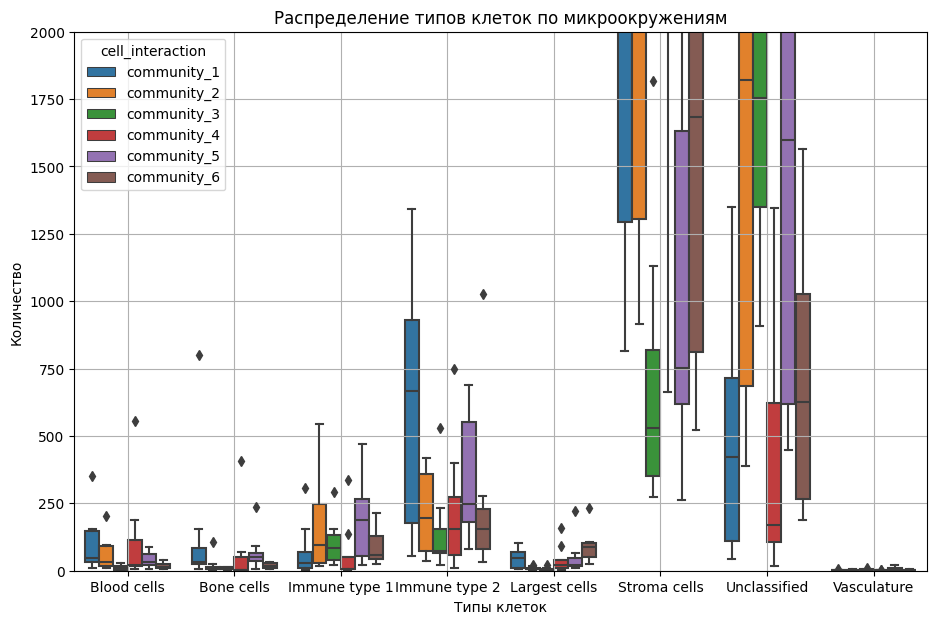

In [29]:
fig = plt.figure(figsize=(11, 7))
boxplot = sns.boxplot(
    data=sample_task2,
    x='cell_type',
    y='count',
    width=0.8,
    hue='cell_interaction'
)
boxplot.set_title('Распределение типов клеток по микроокружениям');
boxplot.set_ylabel('Количество');
boxplot.set_xlabel('Типы клеток');
plt.ylim(0, 2000)
boxplot.grid()

## Задача 3:
Есть ли разница в доле микроокружения в тканях пациентов разных возрастов? Для ответа используйте box_plot/swarplot с hue по возрастным группам, где:

- по Ох будут микроокружения,
- по Оу — их доля в ткани пациента.

Необходимо посчитать доли для каждого пациента отдельно, иначе выборка не будет репрезентативной.

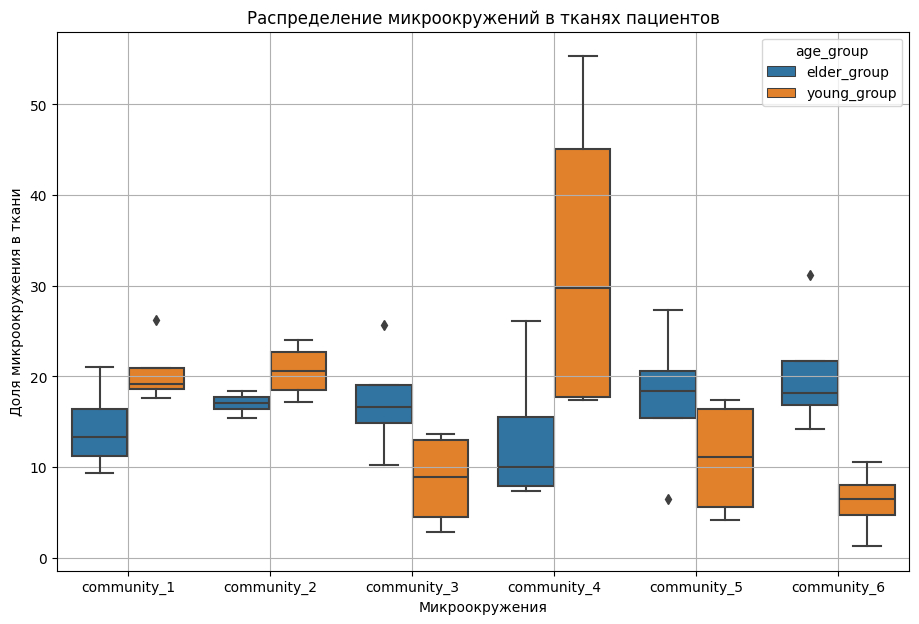

In [30]:
# формируем набор данных - группируем по возрасту, номеру пациента, микроокружению
sample_task3 = (data
    .groupby(['age_group', 'case_id', 'cell_interaction'])
    .size()
    .reset_index(name='count'))
sample_task3['total'] = sample_task3['case_id'].apply(lambda x: 
    sum(sample_task3[sample_task3['case_id'] == x]['count']))
# выразим доли микроокружений в процентах
sample_task3['percent'] = sample_task3['count']/sample_task3['total']*100
#display(sample_task3)

fig = plt.figure(figsize=(11, 7))
boxplot = sns.boxplot(
    data=sample_task3,
    x='cell_interaction',
    y='percent',
    width=0.8,
    hue='age_group')
boxplot.set_title('Распределение микроокружений в тканях пациентов');
boxplot.set_ylabel('Доля микроокружения в ткани');
boxplot.set_xlabel('Микроокружения');
boxplot.grid()

На графике заметна существенная разница в долях микроокружений в тканях пациентов разных возрастов, причем наблюдаются как большие, так и меньшие значения в младшей возрастной группе по сравнению со старшей.

Проведем стат. тест: можно использовать непараметрический U-критерий Манна-Уитни для каждого микроокружения отдельно

In [31]:
alpha = 0.05
H0 = 'Нет значимых различий между возрастными группами'
H1 = 'Между возрастными группами есть значимые различия'

sample_elder = sample_task3[sample_task3['age_group'] == 'elder_group']
sample_young = sample_task3[sample_task3['age_group'] == 'young_group']

stat, p = mannwhitneyu(sample_elder['percent'], sample_young['percent'])
print(f'Для всех микроокружений в совокупности U-статистика: {stat}, p-значение: {p}')
if p < alpha:
    print(f'Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу: {H1} при a = {alpha}')
else:
    print(f'Не отвергаем нулевую гипотезу: {H0} при a = {alpha}')

for i in range(1, 7):
    sample_elder_i = sample_elder['percent'][sample_elder['cell_interaction'] == f'community_{i}']
    sample_young_i = sample_young['percent'][sample_young['cell_interaction'] == f'community_{i}']
    # предполагаем, что доли микроокружений 1, 2, 4 меньше в старшей возрастной группе,
    # а доли микроокружений 3, 5, 6 - в младшей
    alter = 'less' if (i==1 or i==2 or i==4) else 'greater'
    stat, p = mannwhitneyu(sample_elder_i, sample_young_i, alternative=alter)
    print(f'Для {i}-го микроокружения U-статистика: {stat}, p-значение: {p}')
    if p < alpha:
        print(f'Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу: {H1} в {i}-м микроокружении при a = {alpha}')
    else:
        print(f'Не отвергаем нулевую гипотезу: {H0} в {i}-м микроокружении при a = {alpha}')

Для всех микроокружений в совокупности U-статистика: 311.0, p-значение: 0.6426891712062756
Не отвергаем нулевую гипотезу: Нет значимых различий между возрастными группами при a = 0.05
Для 1-го микроокружения U-статистика: 3.0, p-значение: 0.1
Не отвергаем нулевую гипотезу: Нет значимых различий между возрастными группами в 1-м микроокружении при a = 0.05
Для 2-го микроокружения U-статистика: 2.0, p-значение: 0.05714285714285714
Не отвергаем нулевую гипотезу: Нет значимых различий между возрастными группами в 2-м микроокружении при a = 0.05
Для 3-го микроокружения U-статистика: 14.0, p-значение: 0.05714285714285714
Не отвергаем нулевую гипотезу: Нет значимых различий между возрастными группами в 3-м микроокружении при a = 0.05
Для 4-го микроокружения U-статистика: 2.0, p-значение: 0.05714285714285714
Не отвергаем нулевую гипотезу: Нет значимых различий между возрастными группами в 4-м микроокружении при a = 0.05
Для 5-го микроокружения U-статистика: 14.0, p-значение: 0.05714285714285714

По результатам теста Манна-Уитни нулевая гипотеза отвергается только для 6-го микроокружения (при $\alpha = 0.05$). Однако полученные значения для остальных микроокружений малы - p-value <= 0.1.
Можно предположить, что неоднозначность результатов связана с условием для U-критерия Манна-Уитни об отсутствии в сравниваемых группах совпадающих значений признака (все числа – разные) или очень малое число таких совпадений. В данном случае большинство сравнивамых значений лежит в промежутке от 0 до 30 и имеются близкие значения. Поэтому будем опираться в большей степени на визуальный аназиз (boxplot).

### Результаты задачи 3:
Исходя из графика распределения микроокружений в тканях пациентов, а также с учетом малых p-value в тестах Манна-Уитни, предполагаем, что доли микроокружений 1, 2, 4 статистически меньше в старшей возрастной группе, а доли микроокружений 3, 5, 6 статистически меньше в младшей.

**Как можно уточнить анализ:**
увеличить размер выборки, стремясь к сбалансированным группам; устранить выбросы; рассмотреть альтернативные методы визуализации и анализа, например, многомерное масштабирование, кластерный анализ или моделирование смешанных эффектов, которые могут лучше учитывать структуру данных; провести дополнительные анализы, такие как перекрестная проверка или бутстрап.

## Задача 4:
Правда ли, что иммунные клетки (Immune type 1 и Immune type 2) лежат ближе к сосудам и крупным клеткам (Обе колонки distance), чем стромальные клетки (Stroma cells) у молодых, но не у пожилых пациентов? Эту гипотезу нужно проверить бутстрапом (как разницу средних для двух выборок).

In [62]:
# Разделим данные на две группы: молодые пациенты и пожилые пациенты
sample_elder = data[data['age_group'] == 'elder_group']
sample_young = data[data['age_group'] == 'young_group']

In [65]:
from scipy.stats import bootstrap

# функция расчета разницы средних между иммунными и стромальными клетками
def my_stat(data1, data2):
    return np.mean(data1)-np.mean(data2)

# функция, выводящая результаты и эмпирическое распределение
def bootstrap_res(df, distance, group):
    # Отфильтруем данные, оставив только иммунные клетки (Immune type 1 и Immune type 2) и стромальные клетки (Stroma cells)
    sample_immune = df[(df['cell_type'] == 'Immune type 1') |
                    (df['cell_type'] == 'Immune type 2')]
    sample_stroma = df[df['cell_type'] == 'Stroma cells']
    # используем функцию bootstrap из scipy.stats
    res = bootstrap((sample_immune[distance], sample_stroma[distance]),
                    my_stat, confidence_level=0.95, method='percentile', n_resamples=1000)

    print(f'Для {group} 95% доверительный интервал разницы средних {distance} \n\
        между иммунными и стромальными клетками: {res.confidence_interval}')

    # стоим гистограмму полученного распределения
    fig = plt.figure()
    ax = (sns.histplot(
        data=res.bootstrap_distribution,
        bins=25,
        kde=True))
    ax.set_title(f'Bootstrap-распределение разницы средних {distance} для возрастной группы {group}')
    ax.set_xlabel(f'разница средних {distance}')
    ax.set_ylabel('количество значений')
    plt.show()

Для elder 95% доверительный интервал разницы средних distance_to_vasculature 
        между иммунными и стромальными клетками: ConfidenceInterval(low=-31.43683552804184, high=-23.7205756336791)


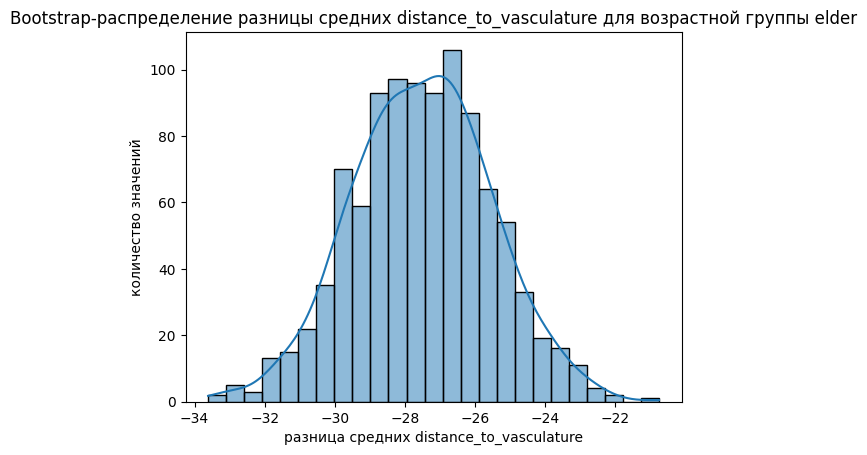

Для elder 95% доверительный интервал разницы средних distance_to_largest_cell 
        между иммунными и стромальными клетками: ConfidenceInterval(low=-22.86356249684799, high=-16.745368838995322)


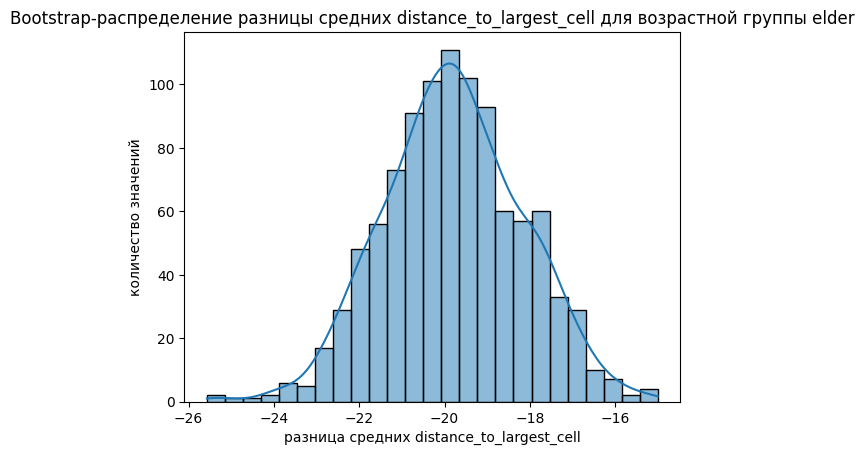

Для young 95% доверительный интервал разницы средних distance_to_vasculature 
        между иммунными и стромальными клетками: ConfidenceInterval(low=-31.629017935072202, high=-23.69509558606856)


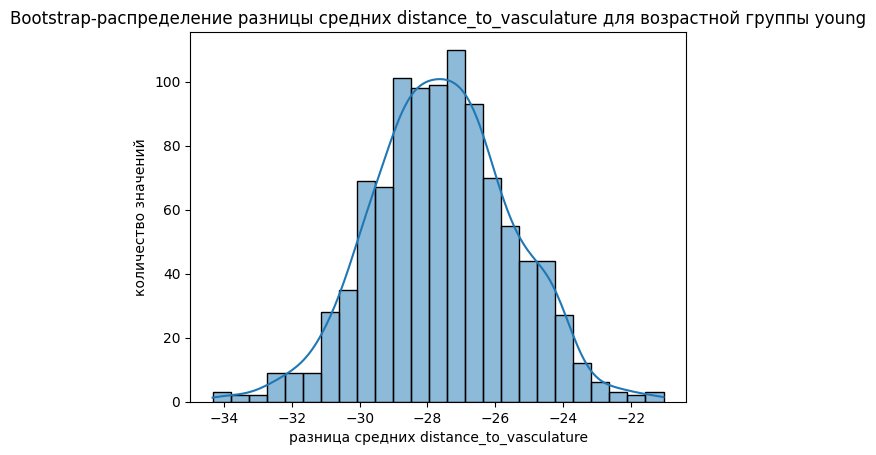

Для young 95% доверительный интервал разницы средних distance_to_largest_cell 
        между иммунными и стромальными клетками: ConfidenceInterval(low=-23.057952228885117, high=-16.695842936623556)


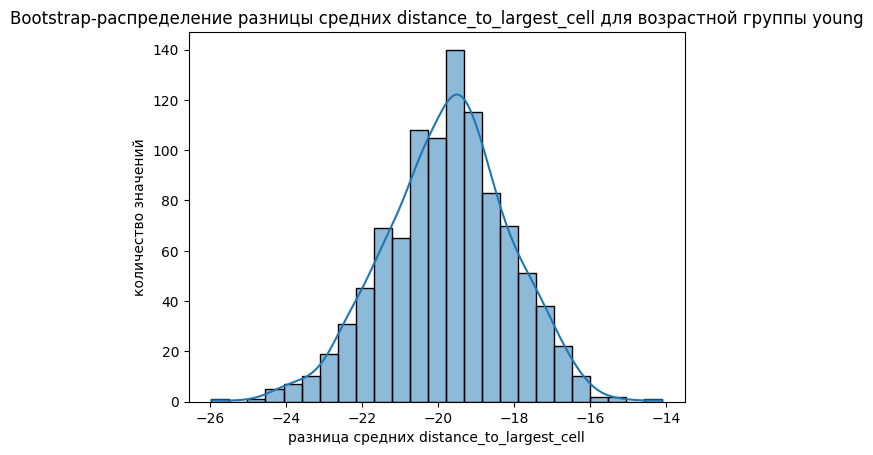

In [66]:
bootstrap_res(sample_elder, 'distance_to_vasculature', 'elder')
bootstrap_res(sample_elder, 'distance_to_largest_cell', 'elder')
bootstrap_res(sample_elder, 'distance_to_vasculature', 'young')
bootstrap_res(sample_elder, 'distance_to_largest_cell', 'young')

### Результаты задачи 4:
Получены доверительные интервалы для разницы средних расстояний до объектов (сосудов и крупных клеткок) между иммуными и стромальными клетками. Ни один из четырех интервало не содержит 0, все значения отрицательные, что указывает на меньшее расстояние между иммунными клетками и объектами, по сравнению с расстоянием от стромальных клеток до объектов. Иначе говоря, иммуные клетки лежат ближе к сосудам и крупным клеткам (колонки distance), чем стромальные клетки и у молодых, и у пожилых пациентов.

## Задача 5:
Правда ли, что иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов? Эту гипотезу необходимо проверить пермутационным тестом. 

В качестве исходной статистики берем массив с расстояниями только для данного типа клеток (длина - n), запоминаем среднее для каждого пациента. На каждой итерации набираем выборку размером n из всей колонки с расстояниями до сосудов и смотрим соотношение с исходной статистикой. Проверяем гипотезы:
- $H_0:$ нет различий в расположении иммунных клеток относительно сосудов между молодой и пожилой группами пациентов
- $H_1:$ расстояния от иммунных клеток до сосудов меменьше у молодых, чем у пожилых.

Комбинировать p-values для каждой возрастной группы можно с помощью scipy.stats.combine_pvalues.

In [68]:
# Отфильтруем данные, оставив только иммунные клетки
sample_elder5 = sample_elder[(sample_elder['cell_type'] == 'Immune type 1') |
                            (sample_elder['cell_type'] == 'Immune type 2')]
sample_young5 = sample_young[(sample_young['cell_type'] == 'Immune type 1') |
                            (sample_young['cell_type'] == 'Immune type 2')]

# Для каждого пациента рассчитаем среднее расстояние иммунных клеток до сосудов
mean_dist_elder = (sample_elder5
                   .groupby('case_id')
                   ['distance_to_vasculature'].mean())
mean_dist_young = (sample_young5
                   .groupby('case_id')
                   ['distance_to_vasculature'].mean())
# Объединим средние значения для всех пациентов в один массив (исходная статистика)
mean_dist = pd.concat([mean_dist_elder, mean_dist_young])
#display(mean_dist)

Пермутационный тест позволяет провести статистическое сравнение между двумя группами (молодыми и пожилыми пациентами), учитывая особенности данных. Также этот тест не требует предположений о распределении данных и позволяет эффективно учитывать взаимосвязи между наблюдениями.
Изпользуем готовую функцию для пермутационного теста из библиотеки scipy.stats

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.permutation_test.html

In [69]:
from scipy.stats import permutation_test

n = len(sample_elder5['distance_to_vasculature'])
res = permutation_test((sample_elder5['distance_to_vasculature'], sample_young5['distance_to_vasculature']), 
                       my_stat, alternative='greater', n_resamples=n)
print(f'Статистика = {res.statistic}, P-value = {res.pvalue}')

Статистика = -149.89503845541458, P-value = 1.0


Значение статистики (разницы средних расстояний) отрицательное, а p-value близко к единице. Это указывает на невозможность отвергнуть нулевую гипотезу в пользу гипотезы $H_1$ и приводит к выдвижению новой альтернативной гипотезы 

- $H_2$ расстояния от иммунных клеток до сосудов меменьше у пожилых, чем у молодых

Кроме того, на эту гипотезу указывал и boxplot из задачи 1в (показан ниже)

Статистика = -149.89503845541458, P-value = 0.0001093972213105787


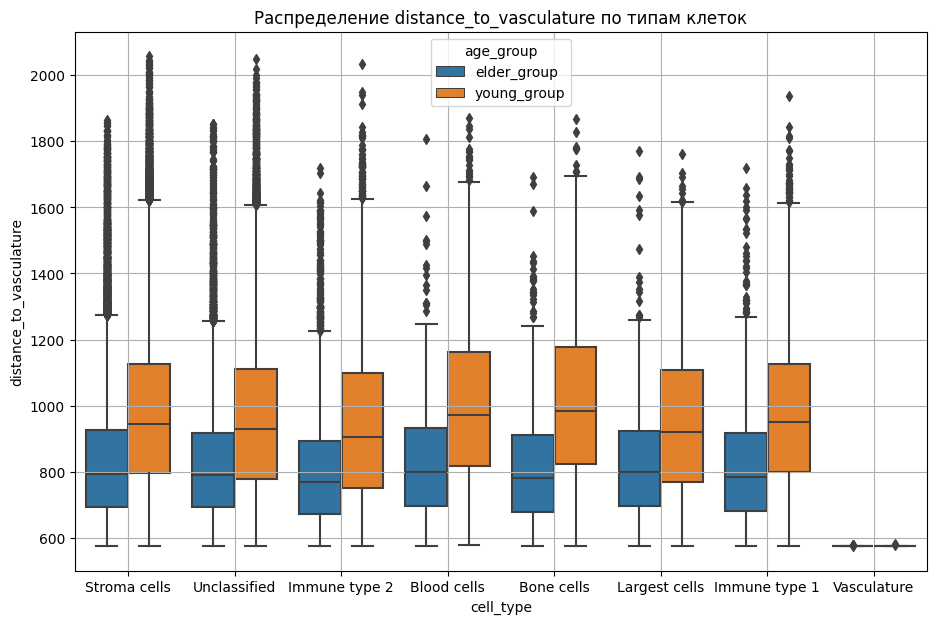

In [71]:
box_plot(data, 'distance_to_vasculature')
res = permutation_test((sample_elder5['distance_to_vasculature'], sample_young5['distance_to_vasculature']), 
                       my_stat, alternative='less', n_resamples=n)
print(f'Статистика = {res.statistic}, P-value = {res.pvalue}')

### Результаты задачи 5:
Получено p-value близкое к 0, что позволяет принять гипотезу: иммунные клетки в среднем лежат ближе к сосудам у пожилых пациентов, по сравнению  молодыми.